<a href="https://colab.research.google.com/github/rkambai/kaggle-russian-sales-predict/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/kaggle/")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statistics
from itertools import product

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
train, test, items, item_cat, shops, sample = pd.read_csv("sales_train.csv"), pd.read_csv("test.csv"),pd.read_csv("items.csv"), pd.read_csv("item_categories.csv"),pd.read_csv("shops.csv"),pd.read_csv('sample_submission.csv')

Some shops have repeated entries, change them to constant value and then dropping duplicate rows

In [ ]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
train.drop_duplicates(inplace=True)

We notice that the train data only contained rows where sales have been made. Thus, occasions where there were no sales at all were omitted, which may result in item_cnt_day predicted values being higher than expected, introducing bias to the model. Thus, the following code creates rows for each month, shop and item where no items have been sold.

In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# compute all shops/items combinations
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [ ]:
new_train = pd.merge(grid,train,on=['shop_id', 'item_id', 'date_block_num'],how='left').fillna(0)

In [ ]:
new_train

,shop_id,item_id,date_block_num,date,item_price,item_cnt_day
0,59,22154,0,02.01.2013,999.0,1.0
1,59,2552,0,0,0.0,0.0
2,59,2554,0,0,0.0,0.0
3,59,2555,0,0,0.0,0.0
4,59,2564,0,0,0.0,0.0
...,...,...,...,...,...,...
12240564,21,7635,33,0,0.0,0.0
12240565,21,7638,33,0,0.0,0.0
12240566,21,7640,33,0,0.0,0.0
12240567,21,7632,33,0,0.0,0.0


Merging of dataframes

In [ ]:
item_merge = pd.merge(items,item_cat,how='left',on='item_category_id')

In [ ]:
merged = pd.merge(new_train, shops, how='left', on='shop_id')

In [ ]:
merged = pd.merge(merged, item_merge, how='left',on='item_id')


In [ ]:
merged.head()

,shop_id,item_id,date_block_num,date,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,59,22154,0,02.01.2013,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,59,2552,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,59,2554,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,59,2555,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,59,2564,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


removing outliers

In [ ]:
merged.describe()

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_category_id
count,1.224057e+07,1.224057e+07,1.224057e+07,1.224057e+07,1.224057e+07,1.224057e+07
mean,3.161502e+01,1.112514e+04,1.491714e+01,2.136670e+02,2.980417e-01,4.418198e+01
std,1.715315e+01,6.250680e+03,9.473315e+00,9.286336e+02,1.387971e+00,1.556708e+01
min,2.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,1.700000e+01,5.631000e+03,7.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01
50%,3.100000e+01,1.116000e+04,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+01
75%,4.700000e+01,1.647900e+04,2.300000e+01,0.000000e+00,0.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.169000e+03,8.300000e+01


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


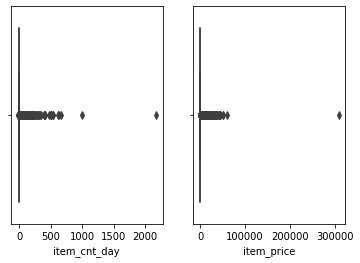

In [ ]:
f, axes = plt.subplots(1,2)
axes[0] = sb.boxplot(merged.item_cnt_day, ax=axes[0])
axes[1] = sb.boxplot(merged.item_price, ax=axes[1])

In [ ]:
condition = ((merged['item_cnt_day']<1000) & (merged['item_price']<100000))

df = merged[condition]

In [ ]:
df.head()

,shop_id,item_id,date_block_num,date,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,59,22154,0,02.01.2013,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,59,2552,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,59,2554,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,59,2555,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,59,2564,0,0,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


Replacing prices in the dataframe with median price found for each item to account for differences in item prices over time. 

In [ ]:
df.loc[(df['item_id'] == 2552)&(df['item_price']>0)].head() ## For example, item 2552 has different prices for these shops

,shop_id,item_id,date_block_num,date,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
8909,25,2552,0,03.01.2013,899.0,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
8910,25,2552,0,05.01.2013,899.0,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
1457026,6,2552,3,25.04.2013,949.0,1.0,"Воронеж (Плехановская, 13)",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
1641312,30,2552,3,25.04.2013,949.0,1.0,"Москва ТЦ ""Перловский""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2073900,4,2552,4,24.05.2013,949.0,1.0,"Волжский ТЦ ""Волга Молл""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


In [ ]:
prices = (pd.DataFrame(train.groupby(by=['item_id']).median())) 

In [ ]:
prices = prices.iloc[:,[2]]

In [ ]:
prices.reset_index(inplace=True)

In [ ]:
df2 = pd.merge(df,prices,on='item_id',how='left')

In [ ]:
df2.drop(columns='item_price_x',inplace=True)
df2.rename(columns={'item_price_y':'item_price'},inplace=True)

In [ ]:
df2.head()

,shop_id,item_id,date_block_num,date,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,item_price
0,59,22154,0,02.01.2013,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.00
1,59,2552,0,0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,949.00
2,59,2554,0,0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,1709.05
3,59,2555,0,0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,1099.00
4,59,2564,0,0,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,349.00


Grouping rows to get item count per month, by=list in order to isolate the label 

In [ ]:
grp = pd.DataFrame((df2.groupby(by=['date_block_num','shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_price'])).sum())

In [ ]:
grp.reset_index(inplace=True)

In [ ]:
grp.rename(columns={"item_cnt_day":"item_cnt_month"},inplace=True)

clipping values from [0,20]

In [ ]:
grp.loc[grp['item_cnt_month']>20,['item_cnt_month']] = 20

In [ ]:
grp.loc[grp['item_cnt_month']<0, ['item_cnt_month']] = 0

In [ ]:
print(grp.item_cnt_month.max(), grp.item_cnt_month.min())

20.0 0.0


Creating columns containing mean price of each item's assigned category, and the ratio of each item's price against the category mean.

In [ ]:
prices_cat = pd.merge(item_merge, prices, on='item_id',how='left').drop(columns=['item_name','item_category_name','item_id'])

In [ ]:
prices_cat = prices_cat.groupby(by='item_category_id').mean()

In [ ]:
prices_cat.rename(columns={'item_price':'cat_mean'},inplace=True)

In [ ]:
grp = pd.merge(grp,prices_cat,on='item_category_id',how='left')

In [ ]:
grp['price_ratio'] = grp['item_price']/grp['cat_mean']

In [ ]:
grp.shape

(10913848, 11)

Adding monthly sales lagged columns, up to last 3 months

In [ ]:
def laggy(df, lags, target):
  tmp = df[['date_block_num','shop_id', 'item_id',target]]
  for i in lags:
    shifted = tmp.copy()
    shifted.columns =['date_block_num','shop_id', 'item_id',target+'_lag'+str(i)]
    shifted['date_block_num']+=i
    df = pd.merge(df,shifted,on=['date_block_num','shop_id', 'item_id'],how='left')
    df[target+'_lag'+str(i)] = df[target+'_lag'+str(i)].astype(float)
  return df


In [ ]:
df = laggy(grp,[1,2,3],'item_cnt_month')

In [ ]:
df.head()

,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_month,cat_mean,price_ratio,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3
0,0,2,"Адыгея ТЦ ""Мега""",19,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,28.0,0.0,217.396749,0.128797,NaN,NaN,NaN
1,0,2,"Адыгея ТЦ ""Мега""",27,"007 Legends [PS3, русская версия]",19,Игры - PS3,1398.0,1.0,1420.332035,0.984277,NaN,NaN,NaN
2,0,2,"Адыгея ТЦ ""Мега""",28,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,249.0,0.0,304.077956,0.818869,NaN,NaN,NaN
3,0,2,"Адыгея ТЦ ""Мега""",29,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,1448.5,0.0,1546.318432,0.936741,NaN,NaN,NaN
4,0,2,"Адыгея ТЦ ""Мега""",32,1+1,40,Кино - DVD,221.0,0.0,217.396749,1.016575,NaN,NaN,NaN


Fixing test data

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
m1 = pd.merge(test, shops, on = 'shop_id', how = 'left')

In [ ]:
m2 = pd.merge(m1, item_merge, on = 'item_id', how = 'left')

In [ ]:
m3 = pd.merge(m2,prices,on='item_id',how='left')

In [ ]:
m3['date_block_num'] = 34

There are some NaN values in item_price due to these items being absent in the train set, perhaps these items have never been sold at all or are new. Replace NaN values with category mean.

In [ ]:
m3 = pd.merge(m3,prices_cat,on='item_category_id',how='left')

In [ ]:
block = m3.loc[m3['item_price'].isna(), ['item_price','cat_mean']] 

In [ ]:
m3.loc[m3['item_price'].isna(),['item_price']] = block['cat_mean']

In [ ]:
m3['price_ratio'] = m3['item_price']/m3['cat_mean']

In [ ]:
m3.head()

,ID,shop_id,item_id,shop_name,item_name,item_category_id,item_category_name,item_price,date_block_num,cat_mean,price_ratio
0,0,5,5037,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",19,Игры - PS3,1999.000000,34,1420.332035,1.407417
1,1,5,5320,"Вологда ТРЦ ""Мармелад""",ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,269.702138,34,269.702138,1.000000
2,2,5,5233,"Вологда ТРЦ ""Мармелад""","Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,599.500000,34,1420.332035,0.422084
3,3,5,5232,"Вологда ТРЦ ""Мармелад""","Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,599.500000,34,1546.318432,0.387695
4,4,5,5268,"Вологда ТРЦ ""Мармелад""","Need for Speed [PS4, русская версия]",20,Игры - PS4,3295.143514,34,3295.143514,1.000000


Now to create lagged columns for test data, we first need to concatenate test data with last three months of train data before running the lag function. 
After which, isolate test rows and set index to ID

In [ ]:
m4 = pd.concat([df.loc[df['date_block_num']>30],m3],axis=0)

In [ ]:
m4.drop(columns=['item_cnt_month_lag1','item_cnt_month_lag2','item_cnt_month_lag3'],inplace=True)

In [ ]:
m4 = laggy(m4,[1,2,3],'item_cnt_month')

In [ ]:
m5 = m4.loc[m4['date_block_num']==34].fillna(0)

In [ ]:
m5.drop(columns=['item_cnt_month'],inplace=True)

In [ ]:
m5.set_index('ID',inplace=True)

In [ ]:
m5.head()

,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,cat_mean,price_ratio,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3
ID,,,,,,,,,,,,,
0.0,34,5,"Вологда ТРЦ ""Мармелад""",5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,1999.000000,1420.332035,1.407417,0.0,1.0,3.0
1.0,34,5,"Вологда ТРЦ ""Мармелад""",5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,269.702138,269.702138,1.000000,0.0,0.0,0.0
2.0,34,5,"Вологда ТРЦ ""Мармелад""",5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,599.500000,1420.332035,0.422084,1.0,3.0,1.0
3.0,34,5,"Вологда ТРЦ ""Мармелад""",5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,599.500000,1546.318432,0.387695,0.0,0.0,1.0
4.0,34,5,"Вологда ТРЦ ""Мармелад""",5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,3295.143514,3295.143514,1.000000,0.0,0.0,0.0


In [ ]:
#df.to_csv('train_cleaned.csv',index=False)
#m5.to_csv('test_cleaned.csv',index=False)

############################################

###START OF TF NN TRIAL

This run achieved an rmse of 1.21935 on Kaggle 

############################################

In [ ]:
df = pd.read_csv('train_cleaned.csv')
m5 = pd.read_csv('test_cleaned.csv')

In [19]:
df = df.dropna()

In [22]:
train_df = df.loc[df['date_block_num']<33] # as data is time series, opt not to use train_test_split
test_df = df.loc[df['date_block_num']==33]
print(train_df.shape, test_df.shape)

(6050508, 14) (127551, 14)


In [23]:
def create_model(my_learning_rate, my_feature_layer):

    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.005),
                                  name='Hidden1'))

    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.005),
                                  name='Hidden2'))
    

    model.add(tf.keras.layers.Dropout(0.2))

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model     

def train_model(model, dataset, epochs, label_name, callback,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, callbacks=[callback], shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# Call the new create_model function and the other (unchanged) functions.

# The following variables are the hyperparameters.



In [24]:
df.columns

Index(['date_block_num', 'shop_id', 'shop_name', 'item_id', 'item_name',
       'item_category_id', 'item_category_name', 'item_price',
       'item_cnt_month', 'cat_mean', 'price_ratio', 'item_cnt_month_lag1',
       'item_cnt_month_lag2', 'item_cnt_month_lag3'],
      dtype='object')

In [25]:
feature_columns = []

to_num = ['date_block_num','shop_id','item_id','item_category_id','item_price','cat_mean','price_ratio','item_cnt_month_lag1',
       'item_cnt_month_lag2', 'item_cnt_month_lag3']
target = "item_cnt_month"
to_cat = ["shop_name", "item_name", "item_category_name"]

for num in to_num:
  add = tf.feature_column.numeric_column(num)
  feature_columns.append(add)

for cat in to_cat:
  vector = feature_column.categorical_column_with_vocabulary_list(cat, df[cat].unique())
  vector_embedding = feature_column.embedding_column(vector, dimension=12)
  feature_columns.append(vector_embedding)


# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)



In [26]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 0.001])
    plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
122/122 [==============================] - 41s 285ms/step - loss: 64890.1250 - mean_squared_error: 64889.8789
Epoch 2/100
122/122 [==============================] - 35s 286ms/step - loss: 3619.3342 - mean_squared_error: 3619.1016
Epoch 3/100
122/122 [==============================] - 35s 288ms/step - loss: 1761.6754 - mean_squared_error: 1761.4473
Epoch 4/100
122/122 [==============================] - 35s 285ms/step - loss: 901.8414 - mean_squared_error: 901.6151
Epoch 5/100
122/122 [==============================] - 35s 286ms/step - loss: 441.1371 - mean_squared_error: 440.9119
Epoch 6/100
122/122 [==============================] - 35s 285ms/step - loss: 229.0927 - mean_squared_error: 228.8686
Epoch 7/100
122/122 [==============================] - 35s 287ms/step - loss: 127.6062 - mean_squared_error: 127.3826
Epoch 8/100
122/122 [==============================] - 3

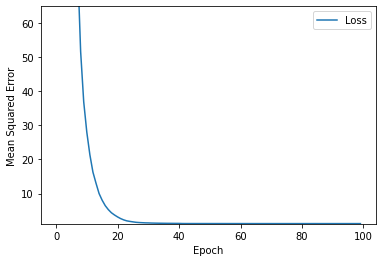


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 1s 58ms/step - loss: 1.1011 - mean_squared_error: 1.0097


[1.1011496782302856, 1.0097100734710693]

In [27]:
learning_rate = 0.0005
epochs = 100
batch_size = 50000
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min')

label_name = "item_cnt_month"

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df, epochs, label_name, callback, batch_size)
plot_the_loss_curve(epochs,mse)
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [28]:
  final_test = {name:np.array(value) for name, value in m5.items()}

In [29]:
submit = pd.DataFrame(data = my_model.predict(x=final_test), columns=['item_cnt_month'])

Consider rewriting this model with the Functional API.


In [30]:
submit.loc[(submit['item_cnt_month']<=0),['item_cnt_month']] = 0

In [31]:
submit.reset_index(inplace=True)
submit.rename(columns={"index":"ID"}, inplace=True)

In [32]:
submit.to_csv("submission_nn.csv", index=False)

########################################

### END OF TF NN TRIAL

########################################

XGBOOST trial

Note: Lineup and shape of data and features must be same in both train and test sets, as well as when using predict.

Target value will be avg_month for this trial as well. An rmse of 1.05572 was attained on Kaggle.

###############################################

In [33]:
df = df.dropna()

In [34]:
df = df[['date_block_num','shop_id','item_id','item_category_id','item_price','cat_mean','price_ratio','item_cnt_month_lag1',
       'item_cnt_month_lag2', 'item_cnt_month_lag3','item_cnt_month']] # only include numeric columns

In [35]:
import xgboost as xgb

In [36]:
train_df = df.loc[df['date_block_num']<33] # as data is time series, opt not to use train_test_split
test_df = df.loc[df['date_block_num']==33]
print(train_df.shape, test_df.shape)

(6050508, 11) (127551, 11)


In [37]:
xgtrain = train_df.drop(columns='item_cnt_month')

In [38]:
dtrain = xgb.DMatrix(xgtrain, label=train_df['item_cnt_month'])

In [39]:
xgtest = test_df.drop(columns='item_cnt_month')

In [40]:
dtest = xgb.DMatrix(xgtest, label=test_df['item_cnt_month'])

In [41]:
params = {'max_depth':10,'eta':0.5,'lambda':0.2,'eval_metric':'rmse'}

In [42]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [43]:
num_round=100
model = xgb.train(params,dtrain,num_round,evallist, early_stopping_rounds=5)

[13:19:15] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-rmse:0.799543	train-rmse:0.853116
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 5 rounds.
[1]	eval-rmse:0.73366	train-rmse:0.758572
[2]	eval-rmse:0.720457	train-rmse:0.730196
[3]	eval-rmse:0.717773	train-rmse:0.716988
[4]	eval-rmse:0.719922	train-rmse:0.705465
[5]	eval-rmse:0.722484	train-rmse:0.698339
[6]	eval-rmse:0.722855	train-rmse:0.691598
[7]	eval-rmse:0.723707	train-rmse:0.687724
[8]	eval-rmse:0.727324	train-rmse:0.683162
[9]	eval-rmse:0.729974	train-rmse:0.680346
[10]	eval-rmse:0.729137	train-rmse:0.677048
[11]	eval-rmse:0.727439	train-rmse:0.67285
[12]	eval-rmse:0.727062	train-rmse:0.670129
[13]	eval-rmse:0.734051	train-rmse:0.667044
[14]	eval-rmse:0.733101	train-rmse:0.6

In [44]:
testdata = m5[['date_block_num','shop_id','item_id','item_category_id','item_price','cat_mean','price_ratio','item_cnt_month_lag1',
       'item_cnt_month_lag2', 'item_cnt_month_lag3']]

In [45]:
final = xgb.DMatrix(testdata)

In [46]:
predicted = model.predict(final)

In [47]:
submit = pd.DataFrame(data=predicted, columns = ['item_cnt_month'])

In [48]:
submit.loc[submit['item_cnt_month']<=0,['item_cnt_month']] = 0
submit.loc[submit['item_cnt_month']>20,['item_cnt_month']] = 20

In [49]:
model.get_score(importance_type='weight')

{'cat_mean': 3022,
 'date_block_num': 15853,
 'item_category_id': 4848,
 'item_cnt_month_lag1': 9051,
 'item_cnt_month_lag2': 8891,
 'item_cnt_month_lag3': 8853,
 'item_id': 8729,
 'item_price': 5829,
 'price_ratio': 5796,
 'shop_id': 12582}

In [50]:
(submit.reset_index().rename(columns={'index':'ID'})).to_csv('submission_xg.csv',index=False)